In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras import Input
#from keras.engine import Model
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
import librosa
import pandas as pd
from PIL import Image
import pathlib
import csv 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers



In [2]:
# prepare known data
volume_path = 'C:/Users/USER/Desktop/spcup_2022_training_part1/spcup_2022_training_part1'

FilePathList = []

for dirName, subdirList, fileList in os.walk(volume_path):
    for filename in fileList:
        if '.csv' not in filename:
            FilePathList.append(volume_path + '/' + filename)
        else:
            pd_label = pd.read_csv(volume_path + '/' + filename)
            print(pd_label)

labels = np.array(pd_label['algorithm'])

                                     track  algorithm
0     00050dd7458cf08e594c797930696bce.wav          4
1     00070e7c531000d3dddc735d107275a9.wav          2
2     000f0711027a69b7f3886c2dbcb7d41f.wav          3
3     001e28e66dee24408aaf3480dfb95fbe.wav          1
4     001eee950f60613869544b72cd48fe97.wav          2
...                                    ...        ...
4995  ffbab00611a4fc3a0f2f1cf58b948dc6.wav          4
4996  ffc71c4290e45f680c7246c54a34187e.wav          4
4997  ffccfe769c16cfbf94984e1770e9018e.wav          0
4998  ffe40cc3261eeda2141a350e5f8d35ca.wav          1
4999  ffff23857c07ea6ecaffd913a909af6f.wav          4

[5000 rows x 2 columns]


In [3]:
sampling_rate = 16000   # 1초에 16000번
n_mels = 64
test_accuracy_all = []

X_train_path, X_test_path, y_train_raw, y_test_raw = train_test_split(np.array(FilePathList), labels, test_size=0.2, stratify=labels, random_state=42)

In [4]:
##train set
fmin = librosa.midi_to_hz(36)
hop_length = 512
y_labels_aug = []
X_mel_aug1 = []
X_mel_aug2 = []
for i, filepath in enumerate(X_train_path):
    y, sr = librosa.load(filepath, mono=True, sr=sampling_rate)
    index_f = 0
    for j in range(y.size // sampling_rate):
        X_aug_seg = y[index_f:index_f + sampling_rate]
        
        S = librosa.feature.melspectrogram(y=X_aug_seg, sr=sampling_rate, n_mels=n_mels, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        X_mel_aug1.append(S_dB)
        
        C = librosa.cqt(X_aug_seg, sr=sr, fmin=fmin, n_bins=64, hop_length=hop_length)
        logC = librosa.amplitude_to_db(np.abs(C))
        X_mel_aug2.append(logC)

        
        y_labels_aug.append(y_train_raw[i])
        index_f = index_f + sampling_rate
        
X_train1 = np.array(X_mel_aug1)
X_train2 = np.array(X_mel_aug2)
y_train1 = np.array(y_labels_aug)
print('train set.shape : ', X_train1.shape)
print('train set.shape : ', X_train2.shape)
print('train set.shape : ', y_train1.shape)

train set.shape :  (25977, 64, 32)
train set.shape :  (25977, 64, 32)
train set.shape :  (25977,)


In [6]:
##test set
fmin = librosa.midi_to_hz(36)
hop_length = 512
y_labels_aug = []
X_mel_aug1 = []
X_mel_aug2 = []
file_split_num = []
for i, filepath in enumerate(X_test_path):
    y, sr = librosa.load(filepath, mono=True, sr=sampling_rate)
    index_f = 0
    for j in range(y.size // sampling_rate):
        X_aug_seg = y[index_f:index_f + sampling_rate]

        S = librosa.feature.melspectrogram(y=X_aug_seg, sr=sampling_rate, n_mels=n_mels, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        X_mel_aug1.append(S_dB)

        C = librosa.cqt(X_aug_seg, sr=sr, fmin=fmin, n_bins=64, hop_length=hop_length)
        logC = librosa.amplitude_to_db(np.abs(C))
        X_mel_aug2.append(logC)

        y_labels_aug.append(y_test_raw[i])

        index_f = index_f + sampling_rate
    file_split_num.append(j + 1)

X_test1 = np.array(X_mel_aug1)
X_test2 = np.array(X_mel_aug2)
y_test1 = np.array(y_labels_aug)
print('splited_test set.shape : ', X_test1.shape)
print('splited_test set.shape : ', X_test2.shape)
print('y_test.shape : ', y_test1.shape)
print(len(file_split_num))

splited_test set.shape :  (6321, 64, 32)
splited_test set.shape :  (6321, 64, 32)
y_test.shape :  (6321,)
1000


In [10]:
print(X_test1[0])
print(X_test2[0])
print(X_train1[0])
print(X_train2[0])

[[-65.89238  -59.057842 -55.356606 ... -65.705154 -64.752106 -63.62646 ]
 [-60.77682  -53.320965 -52.16204  ... -53.479767 -52.02788  -55.280655]
 [-59.676216 -52.96777  -50.816387 ... -41.36172  -41.052963 -49.48522 ]
 ...
 [-63.04285  -49.98987  -46.203808 ... -75.357635 -80.       -80.      ]
 [-52.47677  -39.81237  -36.56897  ... -72.13976  -80.       -80.      ]
 [-52.71893  -39.59773  -36.02304  ... -74.67062  -80.       -80.      ]]
[[-49.681736 -45.432755 -44.47647  ... -50.75271  -54.580997 -61.8396  ]
 [-51.682667 -47.076843 -46.19572  ... -48.75132  -50.021152 -53.59185 ]
 [-49.30222  -45.98603  -45.623165 ... -50.346737 -47.27724  -48.079956]
 ...
 [-63.753674 -20.160343 -11.135181 ... -36.71943  -44.091526 -51.754723]
 [-63.753674 -21.445692 -19.269636 ... -37.975815 -46.595863 -50.31655 ]
 [-63.753674 -25.468874 -15.663653 ... -40.510414 -45.627464 -51.181763]]
[[-70.60612  -65.802216 -60.81656  ... -62.901745 -61.913338 -54.12079 ]
 [-64.46717  -58.512764 -56.89693  ... 

In [ ]:
## cqt만 적용하기

In [26]:
# Data Reshape
print('np.unique(y_train)', np.unique(y_train1))
print('np.unique(y_test)', np.unique(y_test1))

X_train2_reshaped = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], X_train2.shape[2],1)
X_test2_reshaped = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], X_test2.shape[2],1)

print('X_train.shape : ', X_train2_reshaped.shape)
print('X_test.shape : ', X_test2_reshaped.shape)

y_train = y_train1
y_test = y_test1

print('y_train.shape', y_train.shape)
print('y_test.shape : ', y_test.shape)

np.unique(y_train) [0 1 2 3 4]
np.unique(y_test) [0 1 2 3 4]
X_train.shape :  (25977, 64, 32, 1)
X_test.shape :  (6321, 64, 32, 1)
y_train.shape (25977,)
y_test.shape :  (6321,)


In [ ]:
## scaling 하고 채널로 합치기

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
train_scaled1 = scaler.fit_transform(X_train1.reshape(-1, X_train1.shape[-1])).reshape(X_train1.shape)

scaler = StandardScaler()
train_scaled2 = scaler.fit_transform(X_train2.reshape(-1, X_train2.shape[-1])).reshape(X_train2.shape)

In [16]:
train_scaled = np.concatenate((train_scaled1,train_scaled2), axis =0)

In [22]:
print(train_scaled1.shape)

(25977, 64, 32)


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
test_scaled1 = scaler.fit_transform(X_test1.reshape(-1, X_test1.shape[-1])).reshape(X_test1.shape)

scaler = StandardScaler()
test_scaled2 = scaler.fit_transform(X_test2.reshape(-1, X_test2.shape[-1])).reshape(X_test2.shape)

In [18]:
test_scaled = np.concatenate((test_scaled1,test_scaled2), axis =2)

In [19]:
test_scaled.shape

(6321, 64, 64)

In [26]:
# Data Reshape
#채널로 concat
print('np.unique(y_train)', np.unique(y_train1))
print('np.unique(y_test)', np.unique(y_test1))

train1_scaled_reshaped = train_scaled1.reshape(train_scaled1.shape[0], train_scaled1.shape[1], train_scaled1.shape[2],1)
test1_scaled_reshaped = test_scaled1.reshape(test_scaled1.shape[0], test_scaled1.shape[1], test_scaled1.shape[2],1)

train2_scaled_reshaped = train_scaled2.reshape(train_scaled1.shape[0], train_scaled1.shape[1], train_scaled1.shape[2],1)
test2_scaled_reshaped = test_scaled2.reshape(test_scaled1.shape[0], test_scaled1.shape[1], test_scaled1.shape[2],1)
train_scaled_reshaped = np.concatenate((train1_scaled_reshaped,train2_scaled_reshaped), axis =3)
test_scaled_reshaped = np.concatenate((test1_scaled_reshaped,test2_scaled_reshaped), axis =3)

print('X_train.shape : ', train_scaled_reshaped.shape)
print('X_test.shape : ', test_scaled_reshaped.shape)

y_train = y_train1
y_test = y_test1

print('y_train.shape', y_train.shape)
print('y_test.shape : ', y_test.shape)

np.unique(y_train) [0 1 2 3 4]
np.unique(y_test) [0 1 2 3 4]
X_train.shape :  (25977, 64, 32, 2)
X_test.shape :  (6321, 64, 32, 2)
y_train.shape (25977,)
y_test.shape :  (6321,)


In [ ]:
### 합치고 scaling

In [16]:
X_train = np.concatenate((X_train1,X_train2), axis =2)

In [17]:
X_train.shape

(25977, 64, 64)

In [18]:
X_test = np.concatenate((X_test1,X_test2), axis =2)

In [19]:
X_test.shape

(6321, 64, 64)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [21]:
# Data Reshape
print('np.unique(y_train)', np.unique(y_train1))
print('np.unique(y_test)', np.unique(y_test1))

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], X_train_scaled.shape[2],1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], X_test_scaled.shape[2],1)

print('X_train.shape : ', X_train_reshaped.shape)
print('X_test.shape : ', X_test_reshaped.shape)

y_train = y_train1
y_test = y_test1

print('y_train.shape', y_train.shape)
print('y_test.shape : ', y_test.shape)

np.unique(y_train) [0 1 2 3 4]
np.unique(y_test) [0 1 2 3 4]
X_train.shape :  (25977, 64, 64, 1)
X_test.shape :  (6321, 64, 64, 1)
y_train.shape (25977,)
y_test.shape :  (6321,)


In [ ]:
####

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()

#model 2
model.add(layers.BatchNormalization(input_shape=(train_scaled_reshaped.shape[1:])))
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation='relu'))
model.add(MaxPool2D(pool_size=(5, 5)))
model.add(Flatten())
model.add(layers.Dense(5))
model.add(layers.Activation('softmax'))

Epoch 1/500
163/163 [==============================] - ETA: 0s - loss: 0.7192 - accuracy: 0.7550
Epoch 00001: val_loss improved from inf to 0.43837, saving model to C:/Users/USER/Desktop/best_model_mel+cqt\42_spcup_best.h5
163/163 [==============================] - 32s 165ms/step - loss: 0.7192 - accuracy: 0.7550 - val_loss: 0.4384 - val_accuracy: 0.8226
Epoch 2/500
163/163 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8859
Epoch 00002: val_loss improved from 0.43837 to 0.29360, saving model to C:/Users/USER/Desktop/best_model_mel+cqt\42_spcup_best.h5
163/163 [==============================] - 25s 152ms/step - loss: 0.2767 - accuracy: 0.8859 - val_loss: 0.2936 - val_accuracy: 0.8780
Epoch 3/500
163/163 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9164
Epoch 00003: val_loss improved from 0.29360 to 0.22986, saving model to C:/Users/USER/Desktop/best_model_mel+cqt\42_spcup_best.h5
163/163 [==============================] - 25s 152ms/st

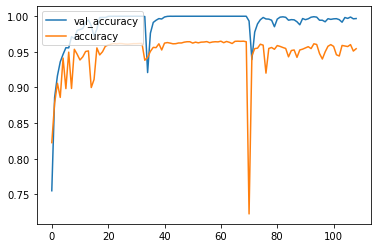

In [28]:
# 모델 컴파일
rs = 42
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, mode='auto') # 원래 patience 100 이었음
model_checkpoint = ModelCheckpoint(filepath="C:/Users/USER/Desktop/best_model_mel+cqt" + "/" + str(rs) + "_" + "spcup_best.h5", monitor='val_loss', verbose=1, save_best_only=True)

classifier = model.fit(train_scaled_reshaped,
                       y_train,
                       epochs=500,
                       batch_size=128, callbacks=[early_stopping, model_checkpoint],
                       validation_split=0.2)

# model_json = model.to_json()
# with open("C:/Users/USER/Desktop/best_model_mel+cqt" + "/" + str(rs) + "_" + "spcup.json", 'w') as json_file:
#     json_file.write(model_json)
model.save_weights("C:/Users/USER/Desktop/best_model_mel+cqt" + "/" + str(rs) + "_" + "spcup.h5")
print("Saved model to disk")

plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.legend(['val_accuracy', 'accuracy'], loc='upper left')

In [44]:
test_loss, test_acc = model.evaluate(test_scaled_reshaped, y_test1, verbose=2)

print('테스트 정확도:', test_acc)

#prediction = model.predict(X_test)

198/198 - 2s - loss: 0.3141 - accuracy: 0.9508 - 2s/epoch - 12ms/step
테스트 정확도: 0.9507989287376404
